In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import time
from sklearn import neighbors
from vast.voidfinder._voidfinder_cython_find_next import MaskChecker
import pickle

<frozen importlib._bootstrap>:219: RuntimeWarning: vast.voidfinder._voidfinder_cython_find_next.HoleGridCustomDict size changed, may indicate binary incompatibility. Expected 312 from C header, got 320 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: vast.voidfinder._voidfinder_cython_find_next.GalaxyMapCustomDict size changed, may indicate binary incompatibility. Expected 320 from C header, got 328 from PyObject


**If observing real galaxy survey, take input of related pickle file**

In [2]:
mask_file_name = "/Users/lorenzomendoza/Desktop/Research/Function/NSA_main_mask.pickle"

In [3]:
temp_infile = open(mask_file_name, "rb")
mask, mask_resolution = pickle.load(temp_infile)
temp_infile.close()

In [4]:
file_name1 = "/Users/lorenzomendoza/Desktop/Research/Function/VoidFinder-nsa_v1_0_1_main_comoving_holes.txt"
data_table_V1 = Table.read(file_name1, format = "ascii.commented_header")

file_name2 = "/Users/lorenzomendoza/Desktop/Research/Function/VoidFinder-nsa_v1_0_1_main_comoving_maximal.txt"
data_table_V1max = Table.read(file_name2, format = "ascii.commented_header")

file_name3 = "/Users/lorenzomendoza/Desktop/Research/Function/VoidFinder-nsa_v1_0_1_main_comoving_holes.txt"
data_table_V2 = Table.read(file_name3, format = "ascii.commented_header")

file_name4 = "/Users/lorenzomendoza/Desktop/Research/Function/VoidFinder-nsa_v1_0_1_main_comoving_maximal.txt"
data_table_V2max = Table.read(file_name4, format = "ascii.commented_header")

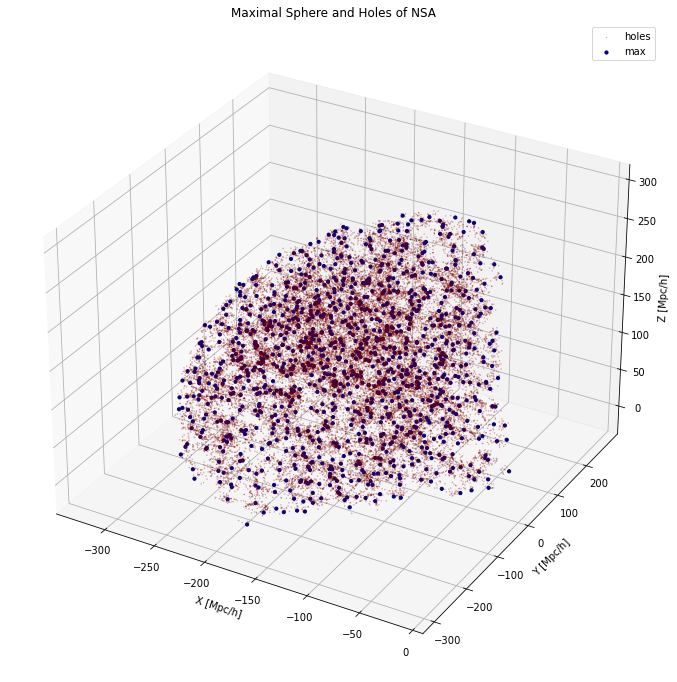

In [5]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(data_table_V1['x'],data_table_V1['y'], data_table_V1['z'],
           color = 'maroon', s=0.1, alpha=0.5,
           label='holes')
ax.scatter(data_table_V1max['x'],data_table_V1max['y'], data_table_V1max['z'],
           color = 'navy', s=10, alpha=1.0,
           label='max')
ax.set(xlabel='X [Mpc/h]', ylabel='Y [Mpc/h]', zlabel='Z [Mpc/h]')

ax.legend(loc='upper right', fontsize=10)

plt.title("Maximal Sphere and Holes of NSA");

In [6]:
def calc_volume_boundaries(void_cat_A, void_cat_B):
    """Compute the boundaries of the minimal rectangular volume (parallelpiped)
    that completely contains two void catalogs.
    
    Parameters
    ----------
    void_cat_A : astropy.Table
        Table of void data from first catalog.
    void_cat_B : astropy.Table
        Table of void data from second catalog.
        
    Returns
    -------
    x_min : float
    x_max : float
    y_min : float
    y_max : float
    z_min : float
    z_max : float
    """
    x_min = np.minimum(np.min(void_cat_A['x']), np.min(void_cat_B['x']))
    x_max = np.maximum(np.max(void_cat_A['x']), np.max(void_cat_B['x']))
    
    y_min = np.minimum(np.min(void_cat_A['y']), np.min(void_cat_B['y']))
    y_max = np.maximum(np.max(void_cat_A['y']), np.max(void_cat_B['y']))

    z_min = np.minimum(np.min(void_cat_A['z']), np.min(void_cat_B['z']))
    z_max = np.maximum(np.max(void_cat_A['z']), np.max(void_cat_B['z']))

    return x_min, x_max, y_min, y_max, z_min, z_max

def generate_grid_points(x_min, x_max, y_min, y_max, z_min, z_max):
    """Creates a dense rectangular grid of points in 3D for the void volume calculation.
    
    Returns
    -------
    xyz : list
        2D list of points in 3D space.
    """
    
    x_range = np.arange(x_min, x_max)
    y_range = np.arange(y_min, y_max)
    z_range = np.arange(z_min, z_max)

    # Creating a meshgrid from the ranges to 
    X,Y,Z = np.meshgrid(x_range,y_range,z_range)

    x_points = np.ravel(X)
    y_points = np.ravel(Y)
    z_points = np.ravel(Z)
    
    point_coords = np.array([x_points, y_points, z_points])
    
    return point_coords

In [7]:
#This line creates the boundaries (like the whole min and max)
xmin, xmax, ymin, ymax, zmin, zmax = calc_volume_boundaries(data_table_V1, data_table_V2)

#This line makes creates the points in between 
pts = generate_grid_points(xmin, xmax, ymin, ymax, zmin, zmax)

b = pts.shape
print(b)

(3, 55431048)


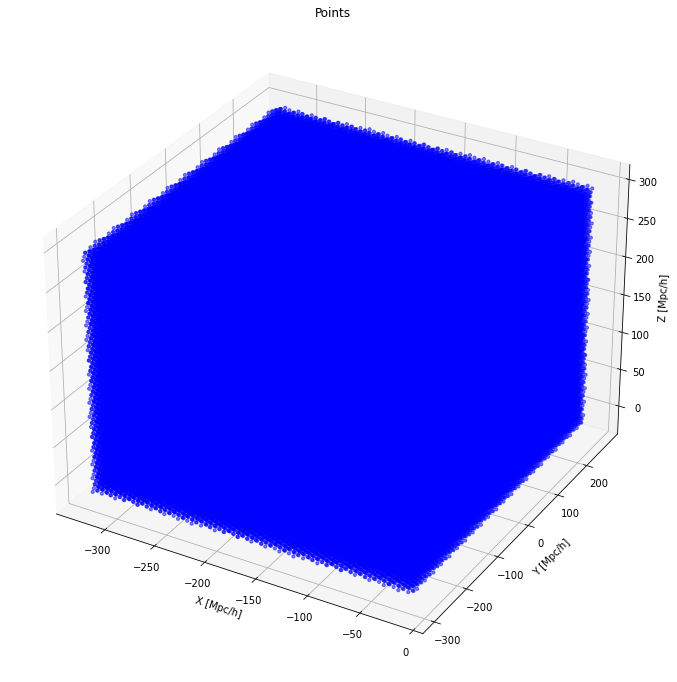

In [8]:
""" This will take the 3D array of pts and plot along each axis
    (x, y, z)
"""
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.scatter(pts[0,::100],pts[1,::100], pts[2,::100],
           color = 'blue', s=10, alpha=0.5,
          )
ax.set(xlabel='X [Mpc/h]',
       ylabel='Y [Mpc/h]',
       zlabel='Z [Mpc/h]')

plt.title("Points from Void Volume");

In [9]:
start_time = time.time()

rmin = 0
rmax = 312.89816 # Where are these computed?

points_boolean = np.ones(pts.shape[1], dtype = bool)

# print(time.time() - start_time)

# Declares MaskChecker object from VAST

mask_checker = MaskChecker(0,
                        mask,
                        mask_resolution,
                        rmin,
                        rmax,)

start_time = time.time()
for i in range(pts.shape[1]):
#     print(pts[:,i].reshape((1,3)).shape)
#     print(pts[:,i].reshape((1,3)))
#     print(pts[:,i])
# Dont Ever Print like this because will store shape of file i times

    # Current point will iterate through all points at 
    
    curr_pt = pts[:,i].reshape((1,3))
    
    # References MC object to declare if not_in_mask
    
    not_in_mask = mask_checker.not_in_mask(curr_pt)
#     print(not_in_mask, not bool(not_in_mask))

    points_boolean[i] = not bool(not_in_mask)
                                    
points_in_mask = pts[:,points_boolean]
(var, n_points) = points_in_mask.shape
print(time.time() - start_time)
print('\nPoints in Mask Shape:', points_in_mask.shape)

print('\nSum of Points IN:', np.sum(points_boolean))

print('\nSum of Points OUT:', np.sum(~points_boolean))

print('\nBoolean Shape:', points_boolean.shape)

print('\nPoints in Mask:',points_in_mask)


88.28506374359131
Points in Mask: 
(3, 23042712)
Sum of Points IN: 
23042712
Sum of Points OUT: 
32388336
Shape: 
(55431048,)
Array: 
[[-107.7976472  -107.7976472  -107.7976472  ... -131.7976472
  -131.7976472  -131.7976472 ]
 [-293.65517841 -293.65517841 -293.65517841 ...  269.34482159
   269.34482159  269.34482159]
 [  -4.61152025   -3.61152025   -2.61152025 ...   86.38847975
    87.38847975   88.38847975]]


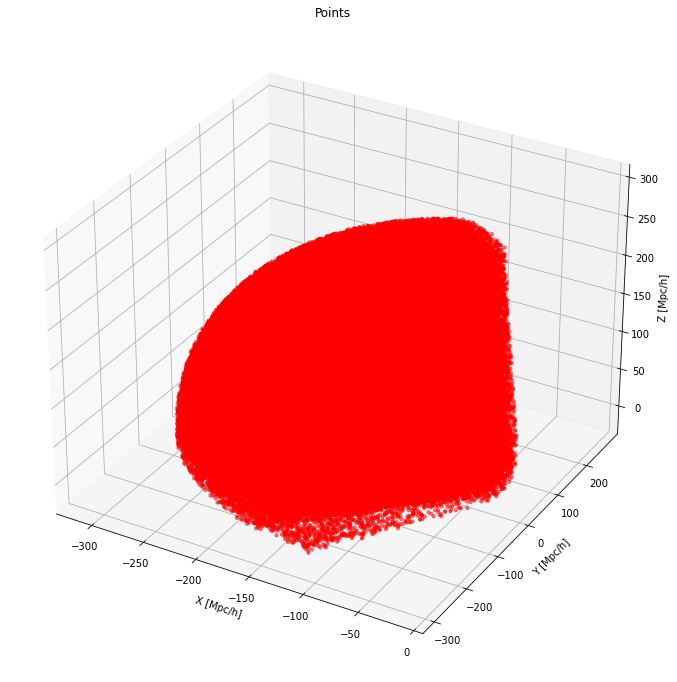

In [10]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
##
# This will take the beautiful 3D array of pts and plot along each axis
# (x, y, z)
##
ax.scatter(points_in_mask[0,::100],points_in_mask[1,::100], points_in_mask[2,::100],
           color = 'red', s=10, alpha=0.5,
          )
ax.set(xlabel='X [Mpc/h]',
       ylabel='Y [Mpc/h]',
       zlabel='Z [Mpc/h]')

plt.title("Points in Mask");

#### KDTree Data Structure: Find closest point given large number of points
- Splits by dimension in halves from middle point
- Stores points as nodes in tree
- Continous to split within halves from middle point and stores childs
- Leafs nodes when splitting can occur no more

- Traverse through tree by dimensions. Levels: X -> Y -> Z -> X...
- Moves to child with nearest coordinate
- Repeats until reaches leaf node, return min dist.
- Travel back up tree and compare with nodes to determine no other possible min dist
- Prunes children with parents > min dist
Complexity: O(d*nlog*n) & O(dn) storage, d - dimensions

In [11]:
def point_query(point_coords, void_cat):
    """We are creating a function to make a KDTree to find the number of points in 
    and out of a catalogue.
    
    Parameters
    ----------
    point_coords: ndarray has a shape of (3,N)
        This is the list of points to query the given void catalogue. N is the number of points given. 
    void_cat: Astropy Table
        This is the given void catalogue.
    
    Returns
    -------
    true_inside: ndarray of shape (N,1)
        Is this the boolean array of length N (same length as point_coords). True means that 1 point 
        is inside the hole.
    """
    
    cx = void_cat['x']
    cy = void_cat['y']
    cz = void_cat['z']

    sphere_coords = np.array([cx, cy, cz])

    start_time = time.time()

    #The .T is meant to transpose the array from (3,1054) to (1054,3)
    sphere_tree = neighbors.KDTree(sphere_coords.T)

    print(time.time() - start_time)

    start_time = time.time()

    dist, idx = sphere_tree.query(point_coords.T, k = 1)

    true_inside = dist < void_cat['radius'][idx]
    
    return true_inside

### Comparison of Void Catalogs
1. Declare False boolean arrays, size 21. Why?
2. Copy points_in_mask data matrix
3. For loop through size of each array
    - Δ = Array size 3 with Random values. Why?
    - Copy each array from points_in_mask and add Δ[i]
    - 
    
    

In [12]:
start_time = time.time()

U = 21

count_in_V1 = np.zeros(U)
count_out_V1 = np.zeros(U)

count_in_V2 = np.zeros(U)
count_out_V2 = np.zeros(U)

inside_both = np.zeros(U)
inside_neither = np.zeros(U)
inside_a = np.zeros(U)
inside_b = np.zeros(U)

points_in_mask_copy = points_in_mask.copy()

for i in range(U):
        
    delta = np.random.rand(3)
    
    points_in_mask_copy[0] = points_in_mask[0] + delta[0]
    points_in_mask_copy[1] = points_in_mask[1] + delta[1]
    points_in_mask_copy[2] = points_in_mask[2] + delta[2]
    
#     print(points_in_mask_copy[:,:10])
    
    true_inside_V1 = point_query(points_in_mask_copy, data_table_V1)

    count_in_V1[i] = np.sum(true_inside_V1)

    # The "~" inverts the array. So we have true_inside inverted to add up the falses instead of the trues
    count_out_V1[i] = np.sum(~true_inside_V1)
    
    # print(time.time() - start_time)

    # total_KIAS = count_in_KIAS + count_out_KIAS

    true_inside_V2 = point_query(points_in_mask_copy, data_table_V2)

    count_in_V2[i] = np.sum(true_inside_V2)

    # The "~" inverts the array. So we have true_inside inverted to add up the falses instead of the trues
    count_out_V2[i] = np.sum(~true_inside_V2)

    #total_DEL = count_in_DEL + count_out_DEL
    
    # This is the number of points that are inside both A and B
    inside_A_and_B = np.logical_and(true_inside_V1, true_inside_V2)
    inside_both[i] = np.sum(inside_A_and_B)
    
    # This is the number of points that are in neither A and B
    not_inside_A_and_B = np.logical_and(~true_inside_V1, ~true_inside_V2)
    inside_neither[i] = np.sum(not_inside_A_and_B)
    
    # This is the number of points that are in A but not B
    inside_A = np.logical_and(true_inside_V1, ~true_inside_V2)
    inside_a[i] = np.sum(inside_A)
    
    # This is the number of points that are not in A but are in B
    inside_B = np.logical_and(~true_inside_V1, true_inside_V2)
    inside_b[i] = np.sum(inside_B)
    
print(time.time() - start_time)
print('\nNumber of points inside KIAS:', count_in_V1)
print('\nNumber of points outside KIAS:', count_out_V1)
print('\nNumber of points inside Delaunay:', count_in_V2)
print('\nNumber of points outside Delaunay:', count_out_V2)
print("\nThis is the total number of points: {}".format(n_points))
# print("\nThis is the total number of points in Delaunay: {}".format(total_DEL))

0.027838945388793945
0.019610166549682617
0.01878190040588379
0.017400264739990234
0.015921831130981445
0.019865989685058594
0.018450021743774414
0.015812158584594727


KeyboardInterrupt: 

### This is the number of points that are inside both A and B

In [13]:
inside_A_and_B = np.logical_and(true_inside_V1, true_inside_V2)

np.sum(inside_A_and_B), count_in_V1, count_in_V2

(13337291,
 array([13324375., 13302919., 13351693., 13337291.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.]),
 array([13324375., 13302919., 13351693.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.]))

### This is the number of points that are in neither A and B

In [14]:
not_inside_A_and_B = np.logical_and(~true_inside_V1, ~true_inside_V2)

np.sum(not_inside_A_and_B), count_in_V1, count_in_V2

(9705421,
 array([13324375., 13302919., 13351693., 13337291.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.]),
 array([13324375., 13302919., 13351693.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.,        0.,        0.,        0.,
               0.,        0.,        0.]))

### This is the number of points that are in A but not B

In [15]:
inside_A = np.logical_and(true_inside_V1, ~true_inside_V2)

np.sum(inside_A)

0

### This is the number of points that are not in A but are in B

In [16]:
inside_B = np.logical_and(~true_inside_V1, true_inside_V2)

np.sum(inside_B)

0

## Fraction of points: Calculate the ratios of the given sums

- in A
- in B
- in A ∧ B
- in ¬(A ∧ B)
- in A ∧¬B
- in B ∧¬A
-   |
-   |
- \ /
- The closer they are to zero, the more similar they are

In [17]:
r_A = count_in_V1 / n_points
print(r_A)

[0.57824682 0.57731568 0.57943236 0.57880735 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [18]:
r_B = count_in_V2 / n_points
print(r_B)

[0.57824682 0.57731568 0.57943236 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


In [19]:
r_AB = np.sum(inside_A_and_B) / n_points
print(r_AB)

0.5788073469824212


In [20]:
r_notAB = np.sum(not_inside_A_and_B) / n_points
print(r_notAB)

0.42119265301757886


In [21]:
r_A_not_B = np.sum(inside_A) / n_points
print(r_A_not_B)

0.0


In [22]:
r_B_not_A = np.sum(inside_B) / n_points
print(r_B_not_A)

0.0


In [23]:
Sum = r_AB + r_notAB + r_A_not_B + r_B_not_A
Sum

1.0

### x̄ & σ of Void Catalogs Ratios

### Catalog 1

In [37]:
average_V1 = np.mean(count_in_V1)
r_average_V1 = average_V1 / n_points
std_V1 = np.std(count_in_V1)
r_std_V1 = std_V1 / n_points

print('\nRatio of V1 Mean:', r_average_V1)
print('\nRatio SD:', r_std_V1)


Ratio of V1 Mean: 0.1101810577223888

Ratio SD: 0.2271443232049065


In [38]:
average_V1_both = np.mean(inside_both)
r_average_V1_both = average_V1_both / n_points

std_V1_both = np.std(inside_both)
r_std_V1_both = std_V1_both / n_points

print(r_average_V1_both)
print(std_V1_both )
print(r_std_V1_both)
print('\nRatio of V1 Mean:', r_average_V1)
print('\nRatio SD:', r_std_V1)

0.08261880310417827
4663249.844387394
0.20237417559128432


In [33]:
average_V1_both = np.mean(inside_b)
r_average_V1_both = average_V1_both / n_points

std_V1_both = np.std(inside_b)
r_std_V1_both = std_V1_both / n_points

print(r_average_V1_both)
print(std_V1_both )
print(r_std_V1_both)

0.0
0.0
0.0
